Assignment: Judging from the diagnostic plots, your data has a problem with both heteroscedasticity and multivariate non-normality. <br><br> heteroscedasticity: No normal distribution with the residual vs predicted values.

multivariate non-normality: The difference beween the actual and predicted values is left skewed

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from functools import reduce
from sklearn import linear_model
from sklearn.model_selection import train_test_split  

In [2]:
crime = pd.read_excel('../data/crime/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls',skiprows=4)
crime.columns = ['city', 'pop', 'violence',
       'manslaughter',
       'rape1', 'rape2',
       'robbery', 'aggravatedassault', 'propcrime', 'burglary',
       'theft', 'vehicletheft', 'arson3']
del crime['rape1']

In [3]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 12 columns):
city                 351 non-null object
pop                  348 non-null float64
violence             348 non-null float64
manslaughter         348 non-null float64
rape2                348 non-null float64
robbery              348 non-null float64
aggravatedassault    348 non-null float64
propcrime            348 non-null float64
burglary             348 non-null float64
theft                348 non-null float64
vehicletheft         348 non-null float64
arson3               187 non-null float64
dtypes: float64(11), object(1)
memory usage: 33.0+ KB


__Method 1 for removing outliers (during data cleaning)__ (Disabled and Maybe doesn't work)

_Find MAD (Median Absolute Deviation) Range_

In [4]:
crime = crime[np.abs(crime.manslaughter-crime.manslaughter.median())<=(3*crime.manslaughter.std())]
crime.info()

__Method 2 for removing outliers (during data cleaning)__ (Disabled)

_Find Quartile Range_

In [5]:
crime.violence.quantile([0.25, 0.75])

__Method 3 for removing outliers (during data cleaning)__ (Disabled)

_Drop MAX Value_

In [6]:
print("Biggest Outlier: \n{}".format(crime.loc[crime['violence'].idxmax()]))
crime = crime.drop(index=216,axis=1)

In [7]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 12 columns):
city                 351 non-null object
pop                  348 non-null float64
violence             348 non-null float64
manslaughter         348 non-null float64
rape2                348 non-null float64
robbery              348 non-null float64
aggravatedassault    348 non-null float64
propcrime            348 non-null float64
burglary             348 non-null float64
theft                348 non-null float64
vehicletheft         348 non-null float64
arson3               187 non-null float64
dtypes: float64(11), object(1)
memory usage: 33.0+ KB


In [8]:
crime.describe()

,pop,violence,manslaughter,rape2,robbery,aggravatedassault,propcrime,burglary,theft,vehicletheft,arson3
count,3.480000e+02,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,187.000000
mean,4.003763e+04,201.594828,1.566092,5.864943,72.902299,121.261494,792.606322,119.683908,637.017241,35.905172,1.871658
std,4.500374e+05,2815.268504,18.303673,60.425452,1031.032873,1706.131730,7659.724746,924.948789,6346.054451,403.423826,10.693411
min,5.260000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.003000e+03,2.000000,0.000000,0.000000,0.000000,1.000000,40.500000,6.000000,31.000000,0.000000,0.000000
50%,7.233500e+03,6.000000,0.000000,0.000000,1.000000,4.000000,112.500000,17.500000,94.000000,2.000000,0.000000
75%,1.842750e+04,22.000000,0.000000,2.000000,5.000000,14.000000,341.000000,51.250000,287.250000,7.000000,1.000000
max,8.396126e+06,52384.000000,335.000000,1112.000000,19170.000000,31767.000000,141971.000000,16606.000000,117931.000000,7434.000000,132.000000


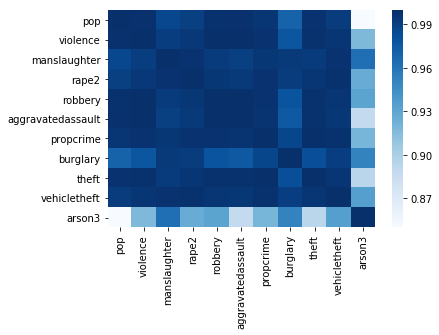

,pop,violence,manslaughter,rape2,robbery,aggravatedassault,propcrime,burglary,theft,vehicletheft,arson3
pop,1.000000,0.998854,0.986758,0.990839,0.998469,0.999134,0.996265,0.970578,0.997946,0.992421,0.701761
violence,0.998854,1.000000,0.992098,0.994985,0.999923,0.999942,0.998059,0.978150,0.998762,0.996271,0.917793
manslaughter,0.986758,0.992098,1.000000,0.997746,0.993104,0.990843,0.995403,0.993733,0.993175,0.997992,0.963200
rape2,0.990839,0.994985,0.997746,1.000000,0.995438,0.994140,0.997843,0.992442,0.996260,0.998764,0.926301
robbery,0.998469,0.999923,0.993104,0.995438,1.000000,0.999742,0.998237,0.979525,0.998735,0.996927,0.931607
aggravatedassault,0.999134,0.999942,0.990843,0.994140,0.999742,1.000000,0.997622,0.976288,0.998561,0.995403,0.888278
propcrime,0.996265,0.998059,0.995403,0.997843,0.998237,0.997622,1.000000,0.987137,0.999666,0.998302,0.920765
burglary,0.970578,0.978150,0.993733,0.992442,0.979525,0.976288,0.987137,1.000000,0.982700,0.991464,0.952121
theft,0.997946,0.998762,0.993175,0.996260,0.998735,0.998561,0.999666,0.982700,1.000000,0.996878,0.893610
vehicletheft,0.992421,0.996271,0.997992,0.998764,0.996927,0.995403,0.998302,0.991464,0.996878,1.000000,0.935194


In [9]:
sns.heatmap(crime.corr(),cmap='Blues',vmax=1,vmin=.85)
plt.show()
crime.corr()

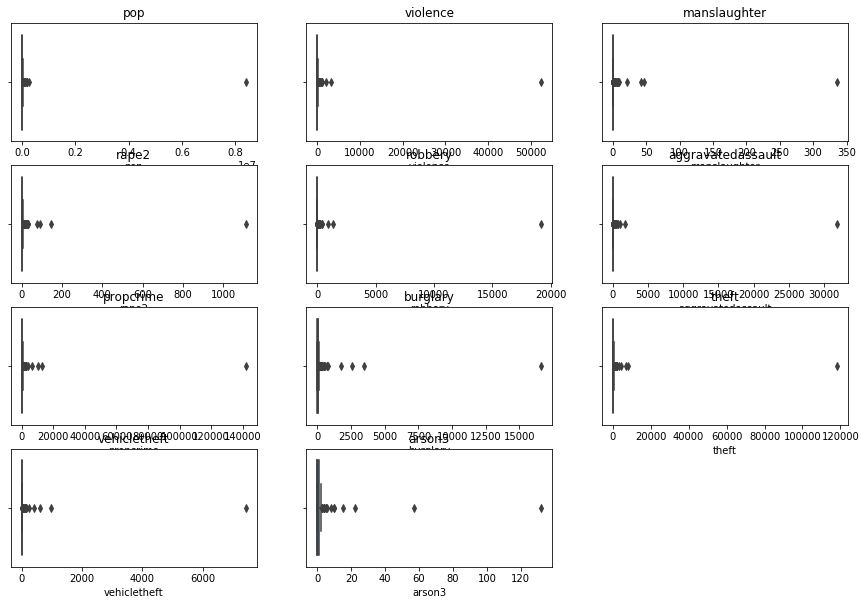

In [10]:
i = 1
fig=plt.figure(figsize=(15,10))

for col in crime.columns[1:]:
    plt.subplot(4, 3, i)
    sns.boxplot(x=crime[col])
    i = i + 1
    plt.title(col)

plt.show()

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

In [11]:
crime = crime.loc[crime['pop'].notnull()]
crime = crime.loc[crime['propcrime'].notnull()]
crime = crime.loc[crime['manslaughter'].notnull()]
crime = crime.loc[crime['pop'].isnull() == False]

In [12]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 0 to 347
Data columns (total 12 columns):
city                 348 non-null object
pop                  348 non-null float64
violence             348 non-null float64
manslaughter         348 non-null float64
rape2                348 non-null float64
robbery              348 non-null float64
aggravatedassault    348 non-null float64
propcrime            348 non-null float64
burglary             348 non-null float64
theft                348 non-null float64
vehicletheft         348 non-null float64
arson3               187 non-null float64
dtypes: float64(11), object(1)
memory usage: 35.3+ KB


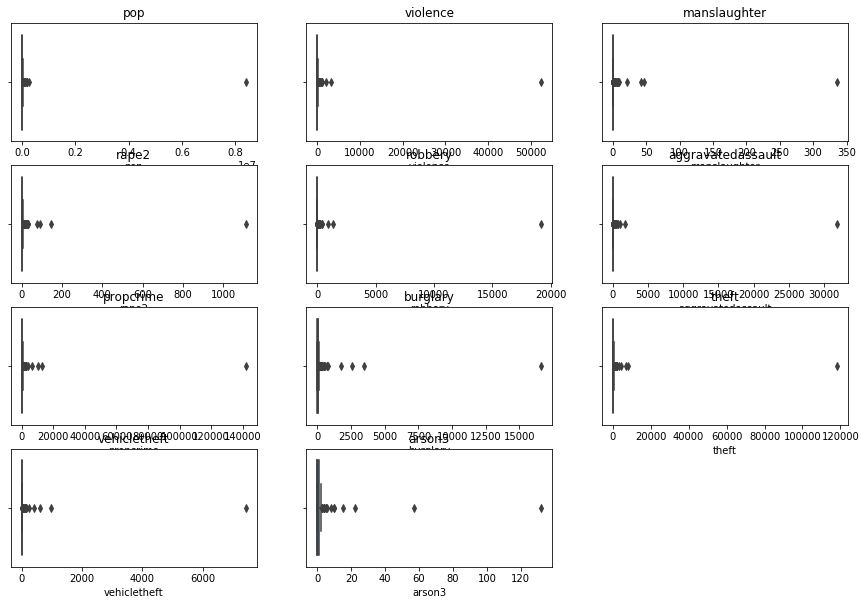

In [13]:
i = 1
fig=plt.figure(figsize=(15,10))

for col in crime.columns[1:]:
    plt.subplot(4, 3, i)
    sns.boxplot(x=crime[col])
    i = i + 1
    plt.title(col)

plt.show()

In [14]:
features = pd.DataFrame()

In [15]:
features['propcrime'] = crime.propcrime
features['pop'] = crime['pop']
features['pop2'] = np.power(crime['pop'],2)
features['rape2'] = crime['rape2'].apply(lambda val: 1 if val > 0 else 0)
features['theft'] = crime['theft'].apply(lambda val: 1 if val > 0 else 0)
features['burglary'] = crime['burglary'].apply(lambda val: 1 if val > 0 else 0)

In [16]:
# Sample data to play with.
features = features.sample(frac=1.0)

y = features['propcrime'].values.reshape(-1, 1)
X = features[['pop','pop2','rape2','theft','burglary']]

print(np.shape(y))
print(np.shape(X))

(348, 1)
(348, 5)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)  

In [18]:
# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

__Method 4 for removing outliers (during linear regression model)__ (Enabled)

_RANSAC Regressor_

In [19]:
#LinearRegression is base_estimator's default, but made explicit to show flexibility                                                   
rfr = linear_model.RANSACRegressor(base_estimator=linear_model.LinearRegression())                                                          

rfr.fit(X_train,y_train)                                                                                                                                             

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=None, random_state=None,
        residual_metric=None, residual_threshold=None, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [20]:
print( 'LinearRegression: {}'.format(regr.score(X_test,y_test)) )                                                                  
print( 'RANSACRegressor: {}'.format(rfr.score(X_test,y_test)) )

LinearRegression: 0.8180019144138432
RANSACRegressor: 0.9189394685766025


In [21]:
# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

Coefficients: 
 [[ 2.97684581e-02 -1.53050877e-09  4.05908963e+01 -2.02800063e+01
  -7.32876760e+01]]
Intercept: 
 [-21.84438253]


In [22]:
regr.score(X_test,y_test)

0.8180019144138432

In [27]:
# Extract predicted values.
predicted = regr.predict(X_test).ravel().reshape(-1,1)
actual = y_test

# Calculate the error, also called the residual.
residual = actual - predicted

print(len(predicted),len(actual),len(residual))
np.shape(predicted)

53 53 53


(53, 1)

In [28]:
# Extract predicted values.
rfrpredicted = rfr.predict(X_test).ravel().reshape(-1,1)
rfractual = y_test

# Calculate the error, also called the residual.
rfrresidual = rfractual - rfrpredicted

np.shape(rfrpredicted)

53 53 53


(53, 1)

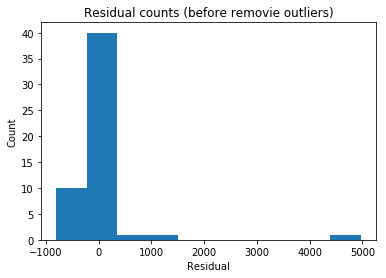

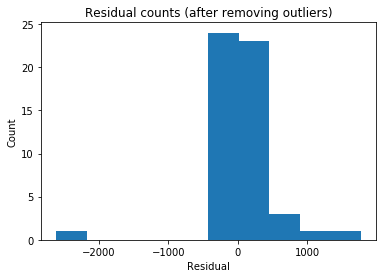

In [30]:
# regular regression
plt.hist(residual)
plt.title('Residual counts (before removie outliers)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# ransac regression
plt.hist(rfrresidual)
plt.title('Residual counts (after removing outliers)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

_No normal distribution_

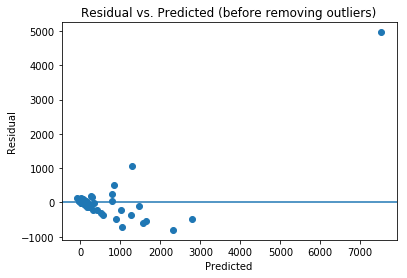

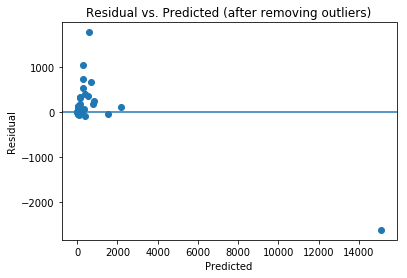

In [31]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted (before removing outliers)')
plt.show()

plt.scatter(rfrpredicted, rfrresidual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted (after removing outliers)')
plt.show()

_Definitely not normally distributed. Has outliers and negative linear trend_

In [33]:
correlation_matrix = X.corr()
display(correlation_matrix)

,pop,pop2,rape2,theft,burglary
pop,1.000000,0.998264,0.087335,0.012352,0.021693
pop2,0.998264,1.000000,0.064167,0.007729,0.013670
rape2,0.087335,0.064167,1.000000,0.120375,0.212913
theft,0.012352,0.007729,0.120375,1.000000,0.479420
burglary,0.021693,0.013670,0.212913,0.479420,1.000000
